In [68]:
# -*- coding: utf-8 -*-
import collections
import itertools
import einops
import numpy as np
import functools
from typing import Optional, Iterator, Literal

import matplotlib.pyplot as plt
import scipy
import scipy.ndimage
import torch
import monai
import monai.transforms.utils
import nibabel as nib
import nibabel.affines
import skimage
import skimage.data, skimage.transform

import mrinr

from test_grid_resample import (
    SpaceToResample,
    get_blob_sample,
    el_coord_grid,
    space_resample_generator,
)

In [2]:
BASIC_SCALE = (1.0,)
BASIC_ROTATION = (0.0,)
BASIC_TRANSLATION = (0.0,)

TEST_SCALES = (0.1, 0.379, 0.5, 0.99, 1.0, 1.0001, 0.5, 1.999, 4.0, 2.0001)
# TEST_SCALES = (2.0,)
TEST_ROTATIONS = (np.pi / 4, np.pi / 2.53, np.pi / 1.179)
TEST_TRANSLATIONS = (-1.36, 0.05, 10.0)

((0.1, 0.1), (0.0,), (0.0, 0.0))
((0.1, 0.379), (0.0,), (0.0, 0.0))
((0.1, 0.5), (0.0,), (0.0, 0.0))
((0.1, 0.99), (0.0,), (0.0, 0.0))
((0.1, 1.0), (0.0,), (0.0, 0.0))
((0.1, 1.0001), (0.0,), (0.0, 0.0))
((0.1, 0.5), (0.0,), (0.0, 0.0))
((0.1, 1.999), (0.0,), (0.0, 0.0))
((0.1, 4.0), (0.0,), (0.0, 0.0))


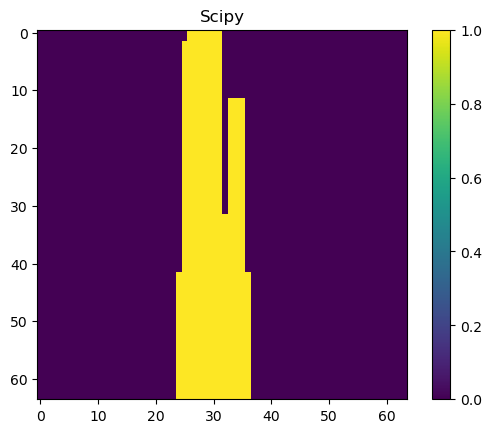

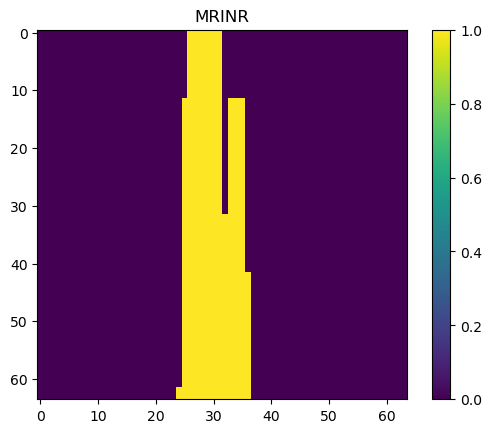

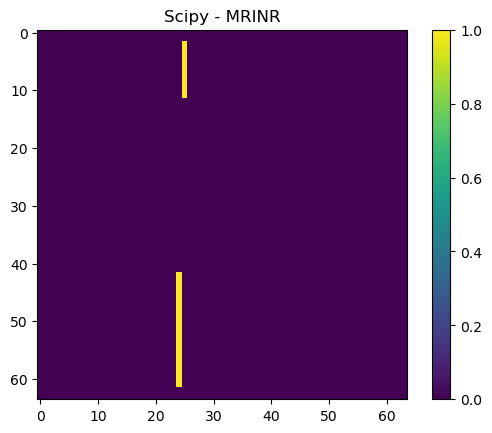

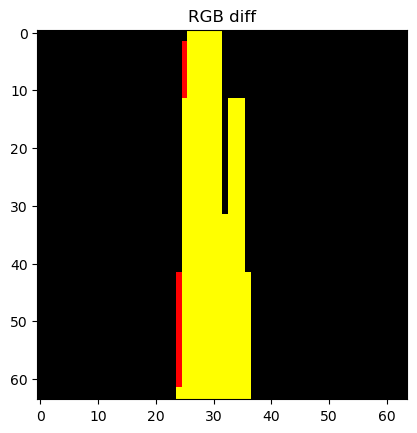

AssertionError: 

In [3]:
scales = TEST_SCALES
# scales = BASIC_SCALE
rotations = BASIC_ROTATION
# rotations = TEST_ROTATIONS
# translations = TEST_TRANSLATIONS
translations = BASIC_TRANSLATION

spatial_dims = 2

s = get_blob_sample(
    64,
    blob_size_fraction=0.2,
    volume_fraction=0.5,
    channels=None,
    batch_size=None,
    spatial_dims=spatial_dims,
    blur_sigma=0.5,
)
for resample_space, tf_params in space_resample_generator(
    spatial_dims=spatial_dims,
    batch_size=None,
    single_x=(s.x > 1e-3).float(),
    single_affine_x_el2coords=s.affine_x_el2coords,
    single_x_coords=s.x_coords,
    scale_factors=scales,
    rotations=rotations,
    translations=translations,
):
    print(tf_params)
    scipy_resample_grid = resample_space.sample_el_coords.movedim(-1, 0).numpy()
    x_tf_scipy = scipy.ndimage.map_coordinates(
        input=resample_space.x.numpy(),
        coordinates=scipy_resample_grid,
        order=0,
        cval=0.0,
        mode="grid-constant",
        # mode="mirror",
        prefilter=True,
    )
    x_tf_scipy = torch.from_numpy(x_tf_scipy)

    # Our sampling function.
    x_tf_mrinr = mrinr.grid_resample(
        x=resample_space.x,
        affine_x_el2coords=resample_space.affine_x_el2coords,
        sample_coords=resample_space.sample_coords,
        interp_lib="torch",
        mode_or_interpolation="nearest",
        # padding_mode_or_bound="reflection",
        padding_mode_or_bound="zeros",
        ###
        # interp_lib="interpol",
        # prefilter=False,
        # mode_or_interpolation="nearest",
        # padding_mode_or_bound="mirror",
    )
    try:
        assert x_tf_mrinr.ndim == spatial_dims
        assert tuple(x_tf_mrinr.shape) == tuple(resample_space.sample_coords.shape[:-1])
        assert x_tf_mrinr.dtype == resample_space.x.dtype

        assert (
            ((x_tf_scipy - x_tf_mrinr).abs() > 1e-4).sum() / x_tf_scipy.numel()
        ) < 0.05

        assert torch.isclose(
            x_tf_scipy,
            x_tf_mrinr,
            atol=1e-4,
        ).all()

    except AssertionError as e:
        plt.figure()
        plt.imshow(x_tf_scipy, interpolation="none", vmin=0, vmax=1)
        plt.colorbar()
        plt.title("Scipy")
        plt.show()
        plt.figure()
        plt.imshow(x_tf_mrinr, interpolation="none", vmin=0, vmax=1)
        plt.colorbar()
        plt.title("MRINR")
        plt.show()
        plt.figure()
        plt.imshow(x_tf_scipy - x_tf_mrinr, interpolation="none")
        plt.colorbar()
        plt.title("Scipy - MRINR")
        plt.show()

        rgb_diff = torch.stack(
            [x_tf_scipy, x_tf_mrinr, torch.zeros_like(x_tf_scipy)], dim=-1
        )
        plt.figure()
        plt.imshow(rgb_diff)
        plt.title("RGB diff")
        plt.show()
        raise e

In [54]:
a = torch.randn(4, 3, 10, 10)
min_ = torch.amin(a, dim=(2, 3), keepdim=True) * 2
max_ = torch.amax(a, dim=(2, 3), keepdim=True) / 1.1
a.clamp(min_, max_).amin((2, 3))
min_.shape

torch.Size([4, 3, 1, 1])

[(0, 0),
 (0, 1),
 (0, 2),
 (1, 0),
 (1, 1),
 (1, 2),
 (2, 0),
 (2, 1),
 (2, 2),
 (3, 0),
 (3, 1),
 (3, 2)]